# Minimal model copy

*Danilo Lessa Bernardineli*

The shortest model ever

In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np

In [2]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 100

sys_params = {
    'max_redeem': [.1]
}

genesis_states = {
    'assets': 100,
    'credit': 100,
    'redeemable':0
}

# Production (exogenous process)
def produce(params, 
                substep, 
                state_history, 
                prev_state):
    amount = np.random.rand()
    return {'production':amount}

def increment_redeemable(params, 
                substep, 
                state_history, 
                prev_state, _input):
    amount = _input['production']
    key = 'redeemable'
    value = prev_state[key] + amount
    return (key,value)

# Deposits (exogenous process)

def deposit(params, 
                substep, 
                state_history, 
                prev_state):
    amount = np.random.rand()
    return {'deposit':amount}

def increment_assets(params, 
                substep, 
                state_history, 
                prev_state, _input):
    amount = _input['deposit']
    key = 'assets'
    value = prev_state[key] + amount
    return (key,value)

def increment_credit(params, 
                substep, 
                state_history, 
                prev_state, _input):
    deposit = _input['deposit']

    #amount = deposit*prev_state['credit']/prev_state['assets']
    amount = ( (1+deposit/prev_state['assets'])**(1/2) -1)*prev_state['credit']

    key = 'credit'
    value = prev_state[key] + amount
    return (key,value)

# Redemptions (exogenous process)

def redeem(params, 
                substep, 
                state_history, 
                prev_state):
    amount = prev_state['redeemable']*np.random.rand()*params['max_redeem']
    return {'withdrawl':amount}

def decrement_redeemable(params, 
                substep, 
                state_history, 
                prev_state, _input):
    amount = _input['withdrawl']
    key = 'redeemable'
    value = prev_state[key] - amount
    return (key,value)

def decrement_credit(params, 
                substep, 
                state_history, 
                prev_state, _input):
    amount = _input['withdrawl']
    key = 'credit'
    value = prev_state[key] - amount
    return (key,value)

def decrement_assets(params, 
                substep, 
                state_history, 
                prev_state, _input):
    withdrawl = _input['withdrawl']

    amount = prev_state['assets']*(prev_state['credit']+prev_state['redeemable']-withdrawl)*withdrawl/(prev_state['redeemable']*prev_state['credit'])

    key = 'assets'
    value = prev_state[key] - amount
    return (key,value)

partial_state_update_blocks = [
    {
        'policies': {produce
            
        },
        'variables': {
            'redeemable': increment_redeemable
        }
    },
    {
        'policies': {deposit
            
        },
        'variables': {
            'assets': increment_assets,
            'credit': increment_credit
        }
    },
    {
        'policies': {redeem
            
        },
        'variables': {
            'assets': decrement_assets,
            'credit': decrement_credit,
            'redeemable': decrement_redeemable
        }
    }
]

sim_config = {
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
    'M': sys_params
}

In [3]:
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

from cadCAD import configs

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=configs)
raw_system_events, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 1, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.01s


In [4]:
df = pd.DataFrame(raw_system_events)

In [5]:
df

,assets,credit,redeemable,simulation,subset,run,substep,timestep
0,100.000000,100.000000,0.000000,0,0,1,0,0
1,100.000000,100.000000,0.641064,0,0,1,1,1
2,100.859946,100.429053,0.641064,0,0,1,2,1
3,96.100338,100.398984,0.610995,0,0,1,3,1
4,96.100338,100.398984,1.392454,0,0,1,1,2
...,...,...,...,...,...,...,...,...
296,10.898642,378.040560,11.103308,0,0,1,2,99
297,10.428184,377.574384,10.637131,0,0,1,3,99
298,10.428184,377.574384,11.165018,0,0,1,1,100
299,10.781929,383.925019,11.165018,0,0,1,2,100


In [6]:
import matplotlib.pyplot as plt

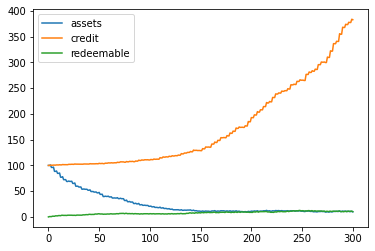

In [7]:
plt.plot(df.index, df.assets.values)
plt.plot(df.index, df.credit.values)
plt.plot(df.index, df.redeemable.values)
plt.legend(['assets','credit','redeemable'])

In [8]:
df['realized_price'] = df.assets.diff()/df.credit.diff() 

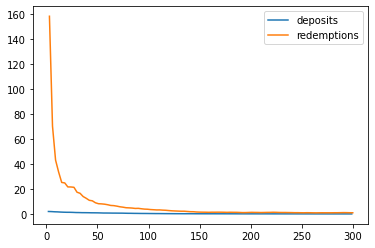

In [9]:
plt.plot(df[df.substep==2].index, df[df.substep==2].realized_price.values)
plt.plot(df[df.substep==3].index, df[df.substep==3].realized_price.values)
plt.legend(['deposits','redemptions'])

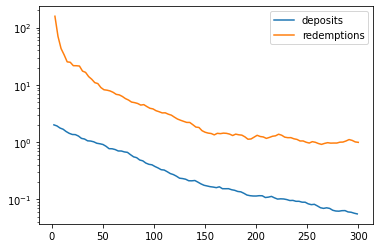

In [11]:
plt.semilogy(df[df.substep==2].index, df[df.substep==2].realized_price.values)
plt.semilogy(df[df.substep==3].index, df[df.substep==3].realized_price.values)
plt.legend(['deposits','redemptions'])